In [22]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("../Donnees/cleaned_data.csv")


# Visualisation

In [23]:
number_columns = ["rating", "retirement", "time", "price", "review_count", "rating_value", "twenty_four_hours", "all_time"]
dfn = df[number_columns]

In [24]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest()
outliers = forest.fit_predict(dfn)



In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


dfn = dfn.drop(index=np.where(outliers==-1)[0])
scaler = StandardScaler()  # Standardize numerical variables
dfn = pd.DataFrame(scaler.fit_transform(dfn), columns=number_columns)


In [42]:
sns.pairplot(dfn)
plt.savefig("pairplot.png")

c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

: 

<Axes: >

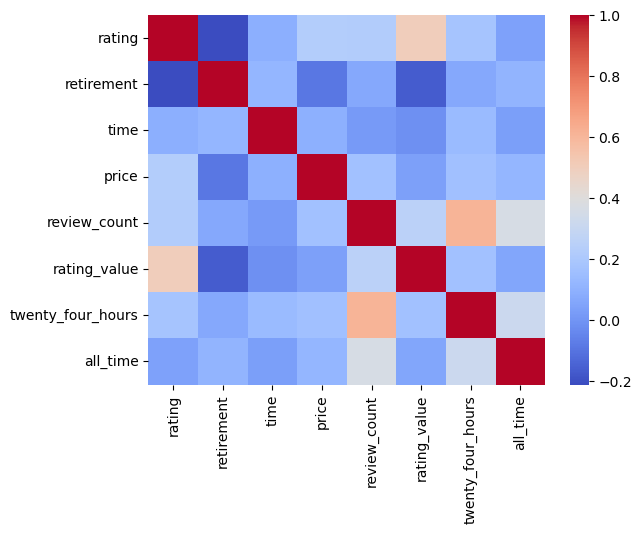

In [7]:
sns.heatmap(dfn.corr(),cmap="coolwarm")

Text(0.5, 0, 'Price')

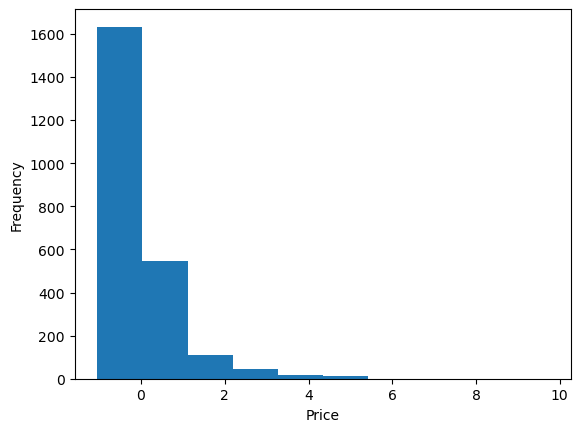

In [22]:
dfn["price"].plot.hist()
plt.xlabel("Price")

Text(0.5, 0, 'Rating')

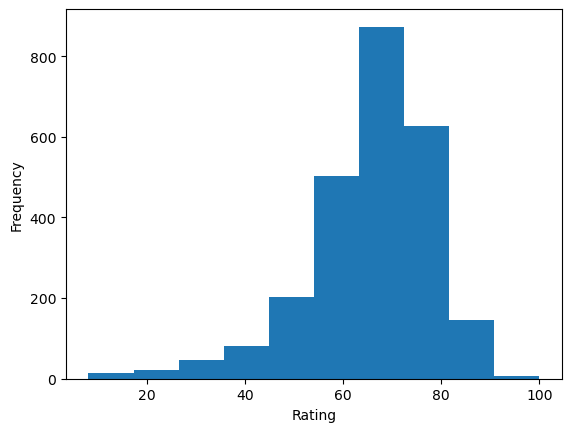

In [23]:
df['rating'].plot.hist()
plt.xlabel("Rating")

<Axes: >

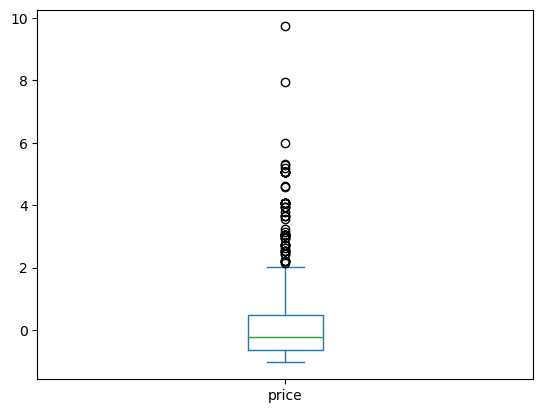

In [24]:
dfn["price"].plot.box()

In [16]:
df.describe()

,hltb_id,rating,retirement,date,time,price,pourcentage_pos,review_count,rating_value,twenty_four_hours,all_time
count,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2.519000e+03,2519.000000,2519.000000,2519.000000
mean,22506.463676,65.855895,8.407860,2012.013497,26.568433,12.111541,80.626439,8.856235e+03,8.161175,479.141326,4510.245335
std,13801.626921,12.818937,5.842482,5.652343,225.881061,49.041570,14.450038,4.288873e+04,1.340184,3734.206846,19947.933810
min,38.000000,8.000000,0.600000,1980.000000,1.000000,0.000000,5.000000,1.000000e+01,2.000000,0.000000,0.000000
25%,9849.500000,60.000000,4.400000,2010.000000,4.208333,3.990000,74.000000,2.170000e+02,7.000000,1.000000,75.000000
50%,21820.000000,68.000000,7.000000,2014.000000,8.933333,8.190000,84.000000,8.710000e+02,9.000000,8.000000,365.000000
75%,34069.000000,74.000000,10.600000,2016.000000,20.000000,14.990000,91.000000,3.520000e+03,9.000000,40.000000,1628.500000
max,48313.000000,100.000000,50.000000,2023.000000,9949.500000,2357.360000,100.000000,1.048001e+06,10.000000,82795.000000,400538.000000


# Traitement des colonnes

In [26]:
import ast

def dummies_list(df):
    df2 = pd.get_dummies(pd.DataFrame(df.values.tolist()), prefix_sep='', prefix='')
    merged_columns = {}
    for col_name, col_data in df2.items():
        if col_name.strip() not in merged_columns:
            merged_columns[col_name.strip()] = col_data
        else:
            merged_columns[col_name.strip()] += col_data
    merged_platform = pd.DataFrame(merged_columns)
    return merged_platform

def X_with_dummies_genres(X):
    X = X.dropna(axis="rows")
    X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)

    X_genre = dummies_list(X.genres)

    #X = X.drop(columns=["genres"])

    #X = pd.merge(X,X_genre,how = "left",left_index=True,right_index=True)

    return X_genre


In [38]:
X_genre.sum()>=50

"1990s"                  True
"Beat em up"             True
"Combats à lépée"       False
"Hack n Slash"          False
"Jeu dargent"           False
                        ...  
Voice Control           False
third-person shooter    False
Évènements rapides      False
Top-down                False
Sous-marin              False
Length: 799, dtype: bool

C:\Users\rapha\AppData\Local\Temp\ipykernel_16596\66625208.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)


<Axes: >

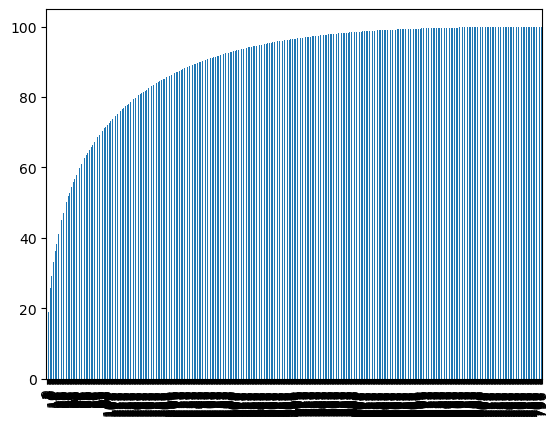

In [27]:
X_genre = X_with_dummies_genres(df)
X_genre = X_genre.drop(index=np.where(outliers==-1)[0])


# reduction de dimension

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_genre)

summary = pd.DataFrame({"variances":pca.explained_variance_,"ratio":pca.explained_variance_ratio_,"cumulative ratio":np.cumsum(pca.explained_variance_ratio_)})
(100*summary['cumulative ratio']).plot.bar()

# Analyses

### PCA

<Axes: >

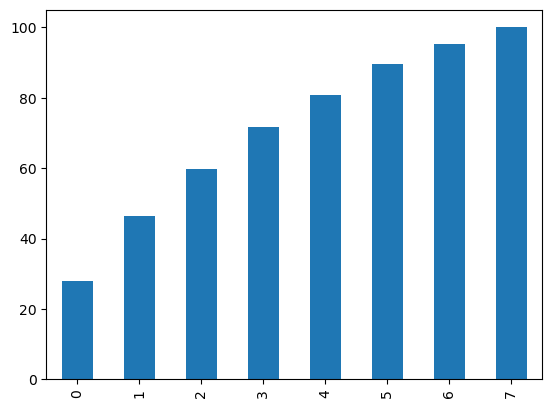

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dfn)
data = scaler.transform(dfn) # normalisation
dataframe = pd.DataFrame(data)
pca = PCA()
pca.fit(dataframe)

summary = pd.DataFrame({"variances":pca.explained_variance_,"ratio":pca.explained_variance_ratio_,"cumulative ratio":np.cumsum(pca.explained_variance_ratio_)})
(100*summary['cumulative ratio']).plot.bar()

2370    8


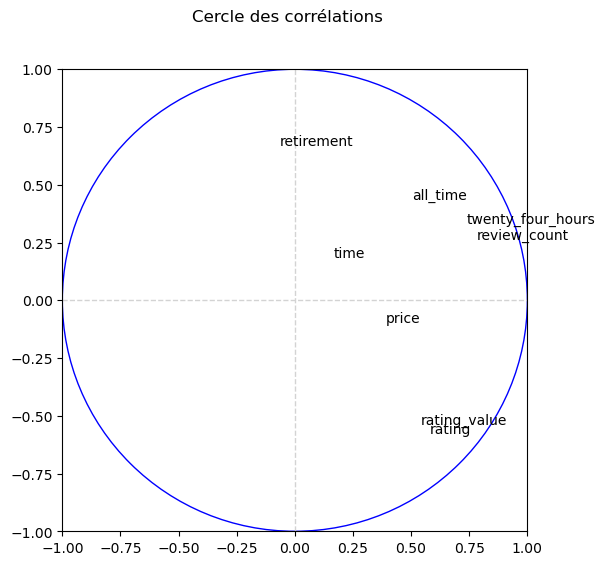

In [29]:
pca_data = pca.transform(dataframe)
pca_data = pd.DataFrame(pca_data).drop([5,6,7],axis='columns') # on ne garde que les 3 premières dimensions (80% de l'information)

# Cercle de correlation 
n = data.shape[0] # nb of individuals
p = data.shape[1] # nb of variables
print(n, '  ', p)
eigval = (n-1) / n * pca.explained_variance_ # eigen values
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p)) # empty matrix for coordinates
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': dfn.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

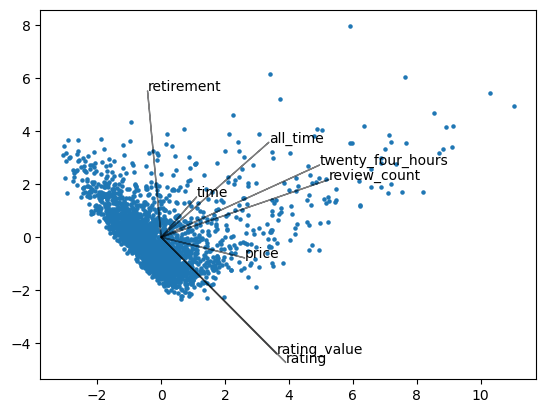

In [31]:
plt.scatter(pca_data[0],pca_data[1],s=5)
for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5)
    plt.text(pca.components_[0,i]*10,pca.components_[1,i]*10,dfn.columns[i])

c:\Users\rapha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


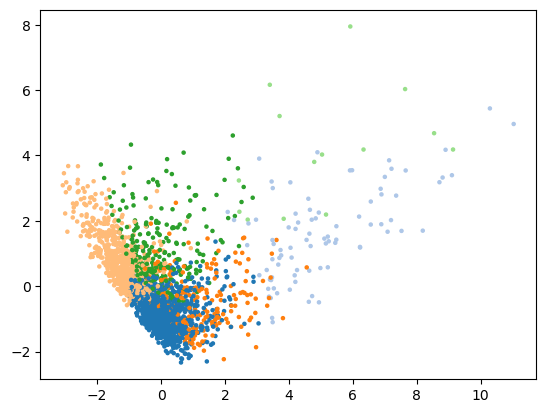

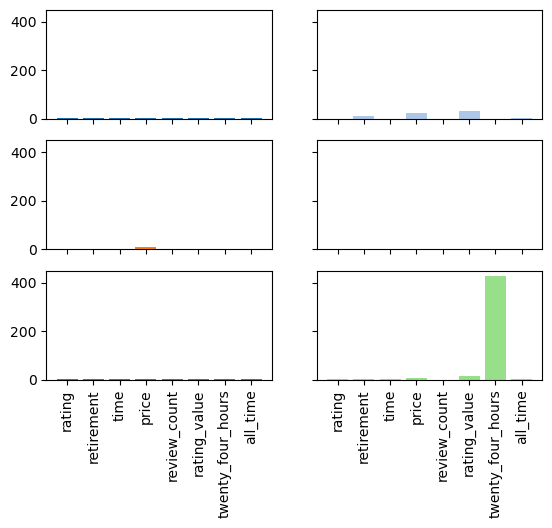

In [37]:
from sklearn.cluster import KMeans
tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=6)
pred = km.fit_predict(data)
plt.scatter(pca_data[0],pca_data[1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)


real_centers = np.exp(pca.inverse_transform(km.cluster_centers_))
fig, axs = plt.subplots(km.n_clusters//2, 2, sharey=True,sharex=True)
for i,k in enumerate(real_centers):
    axs.flatten()[i].bar(range(len(k)),k,color=tab20.colors[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(dfn.columns,rotation="vertical")

### Prédiction du rating en fonction du genre, de la platforme, de la date de sortie et du prix.

In [9]:

def X_with_dummies_genre_platform(X):
    X = X.dropna(axis="rows")
    X['platform'] = X['platform'].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes
    X['genre'] = X['genre'].astype(str).apply(ast.literal_eval)

    X_platform = dummies_list(X.platform)
    X_genre = dummies_list(X.genre)

    X = X.drop(columns=["platform","genre"])

    X = pd.merge(X,X_platform,how = "left",left_index=True,right_index=True)
    X = pd.merge(X,X_genre,how = "left",left_index=True,right_index=True)

    return X

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


# Preprocessing

X = df[['platform', 'genre', 'date', 'price', "time"]]
y = df['rating']
X = X_with_dummies_genre_platform(X)
X = X.drop(index=np.where(outliers==-1)[0])
y = y.drop(index=np.where(outliers==-1)[0])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = list(y_train)
y_test = list(y_test)


model = LinearRegression()

#model = Ridge()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


Mean Squared Error: 114.03462675726163
R-squared: 0.14641099017755133


### Prédiction du retirement en fonction du rating, de la plateforme, du genre, de la date et du prix

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Preprocessing
X = df[['rating',"pourcentage_pos", 'platform', 'genre', 'date', 'price','time',"twenty_four_hours","all_time"]]
y = df['retirement']

X = X_with_dummies_genre_platform(X)

X = X.drop(index=np.where(outliers==-1)[0])
y = y.drop(index=np.where(outliers==-1)[0])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict retirement on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Squared Error: 17.865473510638296
R-squared: 0.3475507871684259


## Clusters

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df[['platform', 'genre', 'rating']]
X = X_with_dummies_genre_platform(X)
#scaler = StandardScaler()  # Standardize numerical variables
#X_scaled = scaler.fit_transform(X_encoded)



c:\Users\rapha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rapha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rapha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


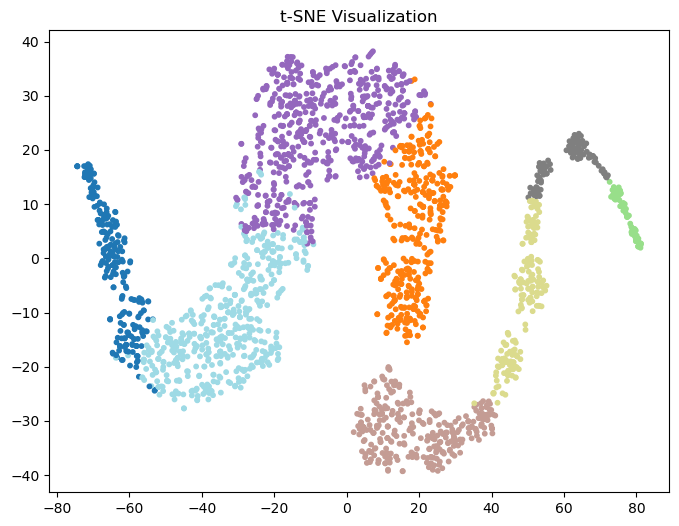

In [15]:
# t-SNE
from sklearn.manifold import TSNE

tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=5)
km.n_clusters = 8
pred = km.fit_predict(X)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=pred, cmap='tab20', s=10)
plt.title('t-SNE Visualization')
plt.show()